In [1]:
import numpy as np
import pandas as pd

In [2]:
ratingData=pd.io.parsers.read_csv("ratings.dat",
           names=["user_id","movie_id","rating","time"],
           engine="python",delimiter="::")
movieData=pd.io.parsers.read_csv("movies.dat",
           names=["movie_id","title","genre"],
           engine="python",delimiter="::", encoding='latin-1')

In [3]:
print(ratingData)

         user_id  movie_id  rating       time
0              1      1193       5  978300760
1              1       661       3  978302109
2              1       914       3  978301968
3              1      3408       4  978300275
4              1      2355       5  978824291
...          ...       ...     ...        ...
1000204     6040      1091       1  956716541
1000205     6040      1094       5  956704887
1000206     6040       562       5  956704746
1000207     6040      1096       4  956715648
1000208     6040      1097       4  956715569

[1000209 rows x 4 columns]


In [4]:
print(movieData)

      movie_id                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
3878      3948             Meet the Parents (2000)   
3879      3949          Requiem for a Dream (2000)   
3880      3950                    Tigerland (2000)   
3881      3951             Two Family House (2000)   
3882      3952               Contender, The (2000)   

                             genre  
0      Animation|Children's|Comedy  
1     Adventure|Children's|Fantasy  
2                   Comedy|Romance  
3                     Comedy|Drama  
4                           Comedy  
...                            ...  
3878                        Comedy  
3879                         Drama  
3880              

In [5]:
ratingMatrix = np.ndarray(
    shape=(np.max(ratingData.movie_id.values), np.max(ratingData.user_id.values)),
    dtype=np.uint8)
ratingMatrix[ratingData.movie_id.values-1, ratingData.user_id.values-1] = ratingData.rating.values
print(ratingMatrix)

[[  5  68 183 ...   0   0   3]
 [  0   0   0 ...   0   0   0]
 [ 84   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [6]:
normalizedMatrix = ratingMatrix - np.asarray([(np.mean(ratingMatrix, 1))]).T
print(normalizedMatrix)

[[-8.15364238e+00  5.48463576e+01  1.69846358e+02 ... -1.31536424e+01
  -1.31536424e+01 -1.01536424e+01]
 [-2.98846026e+01 -2.98846026e+01 -2.98846026e+01 ... -2.98846026e+01
  -2.98846026e+01 -2.98846026e+01]
 [ 3.80827815e+01 -4.59172185e+01 -4.59172185e+01 ... -4.59172185e+01
  -4.59172185e+01 -4.59172185e+01]
 ...
 [-3.27814570e-02 -3.27814570e-02 -3.27814570e-02 ... -3.27814570e-02
  -3.27814570e-02 -3.27814570e-02]
 [-2.58278146e-02 -2.58278146e-02 -2.58278146e-02 ... -2.58278146e-02
  -2.58278146e-02 -2.58278146e-02]
 [-2.42880795e-01 -2.42880795e-01 -2.42880795e-01 ... -2.42880795e-01
  -2.42880795e-01 -2.42880795e-01]]


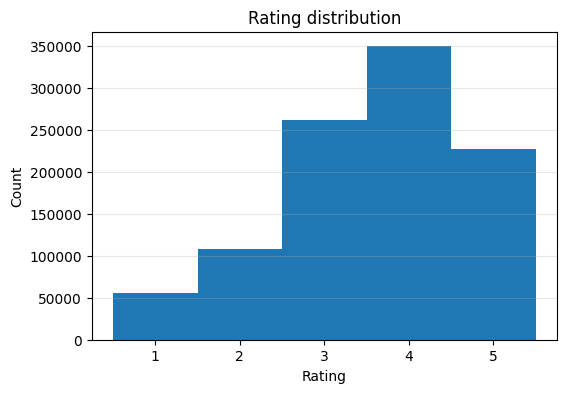

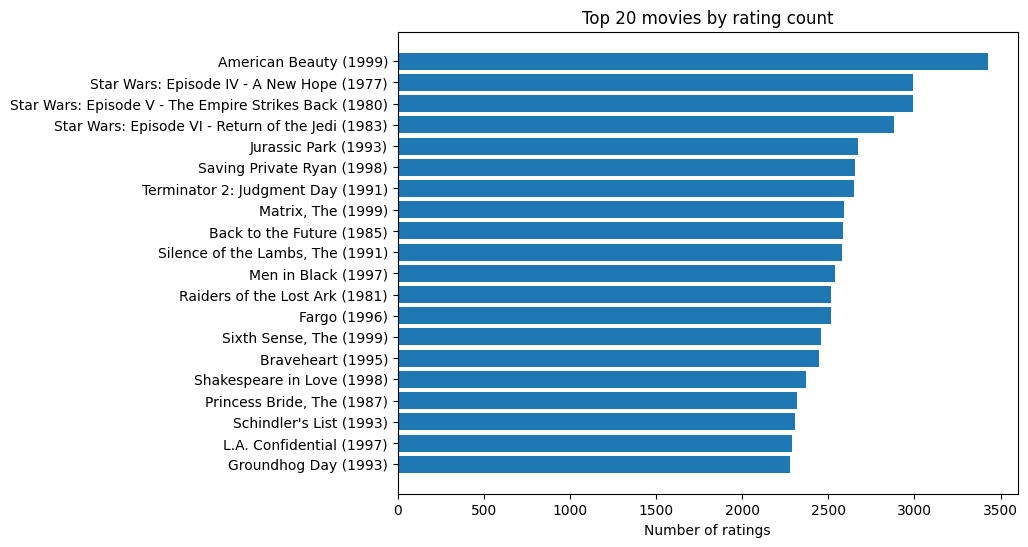

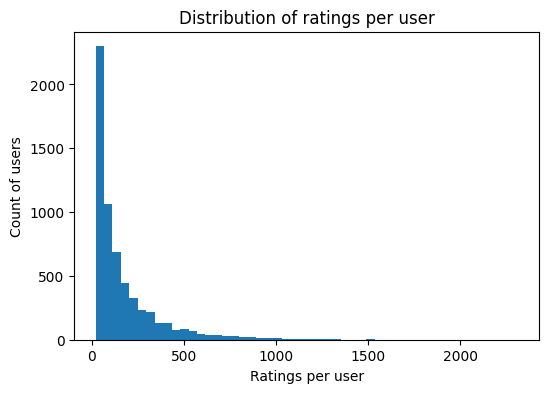

In [10]:
## EDA & visualizations ##
import matplotlib.pyplot as plt

# Rating distribution
plt.figure(figsize=(6,4))
plt.hist(ratingData['rating'], bins=np.arange(1, 7)-0.5)
plt.xticks([1,2,3,4,5])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating distribution')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Top movies
top_movies_counts = ratingData['movie_id'].value_counts().head(20)
top_movie_titles = movieData.set_index('movie_id').loc[top_movies_counts.index].title

plt.figure(figsize=(8,6))
plt.barh(range(len(top_movies_counts)), top_movies_counts.values)
plt.yticks(range(len(top_movies_counts)), top_movie_titles)
plt.gca().invert_yaxis()
plt.xlabel('Number of ratings')
plt.title('Top 20 movies by rating count')
plt.show()

# Ratings per user
user_counts = ratingData['user_id'].value_counts()
plt.figure(figsize=(6,4))
plt.hist(user_counts, bins=50)
plt.xlabel('Ratings per user')
plt.ylabel('Count of users')
plt.title('Distribution of ratings per user')
plt.show()

Working with 1000 users and 1000 movies
Rating matrix sample:
[[5. 5. 0. 0. 4.]
 [4. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [4. 2. 0. 3. 0.]
 [3. 0. 2. 0. 4.]]


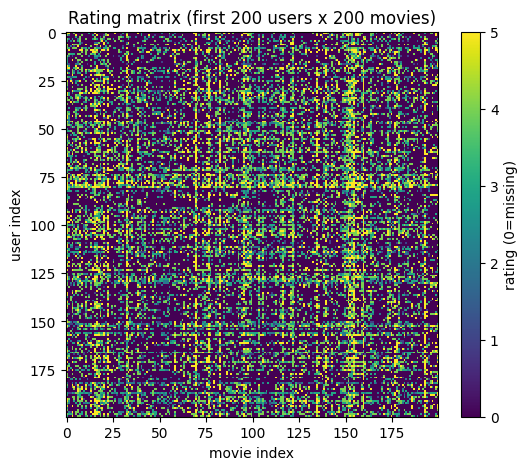

In [12]:
## Build user-movie rating matrix ##

TOP_N_USERS = 1000
TOP_N_MOVIES = 1000

top_users = ratingData['user_id'].value_counts().head(TOP_N_USERS).index
top_movies = ratingData['movie_id'].value_counts().head(TOP_N_MOVIES).index

ratings_small = ratingData[ratingData['user_id'].isin(top_users) & ratingData['movie_id'].isin(top_movies)].copy()

# Reindex
user_map = {uid: i for i, uid in enumerate(sorted(ratings_small['user_id'].unique()))}
movie_map = {mid: i for i, mid in enumerate(sorted(ratings_small['movie_id'].unique()))}

ratings_small['user_idx'] = ratings_small['user_id'].map(user_map)
ratings_small['movie_idx'] = ratings_small['movie_id'].map(movie_map)

n_users = len(user_map)
n_movies = len(movie_map)
print(f'Working with {n_users} users and {n_movies} movies')

# Build dense rating matrix
rating_matrix = np.zeros((n_users, n_movies), dtype=np.float32)
observed_mask = np.zeros_like(rating_matrix, dtype=bool)
for r in ratings_small.itertuples():
    rating_matrix[r.user_idx, r.movie_idx] = r.rating
    observed_mask[r.user_idx, r.movie_idx] = True

print('Rating matrix sample:')
print(rating_matrix[:5, :5])

# Visualize block
plt.figure(figsize=(6,5))
plt.imshow(rating_matrix[:200, :200], aspect='auto', interpolation='nearest')
plt.colorbar(label='rating (0=missing)')
plt.title('Rating matrix (first 200 users x 200 movies)')
plt.xlabel('movie index')
plt.ylabel('user index')
plt.show()

In [20]:
# Perform SVD on the rating_matrix
A = rating_matrix - np.mean(rating_matrix, axis=0) # Center the matrix
U, S, V = np.linalg.svd(A)

In [13]:
def similar(ratingData, movie_id, top_n):
    index = movie_id - 1 # Movie id starts from 1
    movie_row = ratingData[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', ratingData, ratingData)) #Einstein summation |  traditional matrix multiplication and is equivalent to np.matmul(a,b)
    similarity = np.dot(movie_row, ratingData.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity) #Perform an indirect sort along the given axis (Last axis)
    return sort_indexes[:top_n]

In [14]:
k = 50
movie_id = 2
top_n = 10

sliced = V.T[:, :k] # representative data
indexes = similar(sliced, movie_id, top_n)

print('Recommendations for Movie {0}: \n'.format(
movieData[movieData.movie_id == movie_id].title.values[0]))
for id in indexes + 1:
    print(movieData[movieData.movie_id == id].title.values[0])

Recommendations for Movie Jumanji (1995): 

Jumanji (1995)
Richard III (1995)
Persuasion (1995)
It Takes Two (1995)
GoldenEye (1995)
Money Train (1995)
Restoration (1995)
Across the Sea of Time (1995)
Sense and Sensibility (1995)
Assassins (1995)


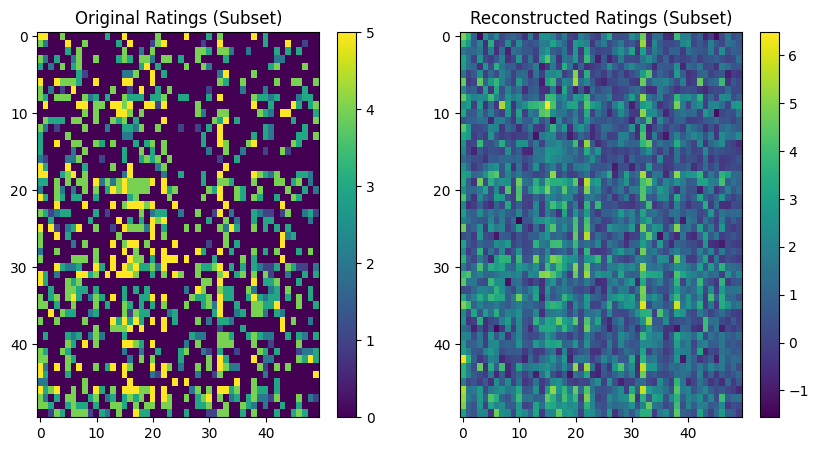

RMSE of reconstructed ratings: 1.5728207573691928


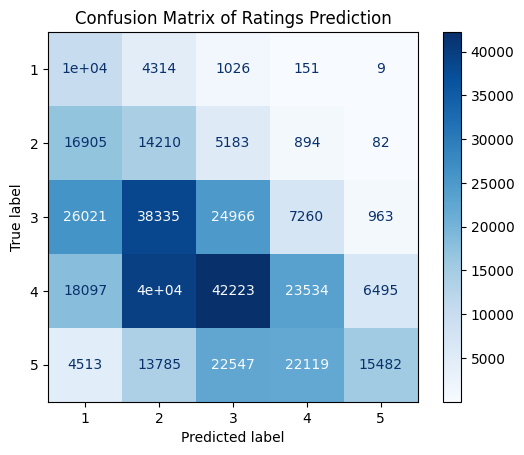

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay

# 1. Reconstruct the rating matrix using top k components
k = 50
approx_ratingMatrix = np.dot(U[:, :k], np.dot(np.diag(S[:k]), V[:k, :])) # V is already transposed in np.linalg.svd
approx_ratingMatrix += np.mean(rating_matrix, axis=0)  # add the mean back

# 2. Plot Original vs Reconstructed Ratings for a subset of movies/users
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(rating_matrix[:50, :50], aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Original Ratings (Subset)")

plt.subplot(1,2,2)
plt.imshow(approx_ratingMatrix[:50, :50], aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Reconstructed Ratings (Subset)")
plt.show()

# 3. Compute RMSE (accuracy metric)
mask = rating_matrix > 0  # consider only rated entries
rmse = np.sqrt(mean_squared_error(rating_matrix[mask], approx_ratingMatrix[mask]))
print("RMSE of reconstructed ratings:", rmse)

# 4. Compute confusion matrix for rounded ratings (1-5)
true_ratings = rating_matrix[mask]
pred_ratings = np.rint(approx_ratingMatrix[mask]).astype(int)
pred_ratings[pred_ratings > 5] = 5
pred_ratings[pred_ratings < 1] = 1

cm = confusion_matrix(true_ratings, pred_ratings, labels=[1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix of Ratings Prediction")
plt.show()